# CAE-MLP Model Analysis for Kolmogorov Flow

## Contents:
1. Load trained model and configuration
2. Training history analysis
3. Reconstruction quality evaluation
4. Latent space analysis
5. Prediction accuracy assessment
6. Long-term prediction stability
7. Model interpretability

In [1]:
import os
import sys
import json
import yaml
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

from src.models.CAE_MLP.caemlp import CAE_LinearMLP, CAE_WeakLinearMLP
from src.models.CAE_MLP.utils import create_caemlp_dataloaders, reshape_data_for_cae

# Set plotting parameters
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load Model and Configuration

##### CAE_LinearMLP

In [3]:
# %% Load configuration and model - CAE_LinearMLP Only
# Specify the experiment folder for CAE_LinearMLP
experiment_folder = "results/checkpoints/CAE_MLP/kolmogorov_CAE_LinearMLP_20250618_162024"
experiment_path = Path(project_root) / experiment_folder

print(f"Loading CAE_LinearMLP experiment from: {experiment_path}")

# Load configuration
config_path = experiment_path / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Verify model type
assert config['model']['type'] == 'CAE_LinearMLP', f"Expected CAE_LinearMLP but got {config['model']['type']}"

print("\nConfiguration:")
print(f"Model type: {config['model']['type']}")
print(f"Training mode: {config['training']['train_mode']}")
print(f"Latent dimension: {config['model']['params']['latent_dim']}")

# Load training history
history_path = experiment_path / "training_history.json"
with open(history_path, 'r') as f:
    history = json.load(f)

# Load losses
losses_path = experiment_path / "losses" / "losses.json"
with open(losses_path, 'r') as f:
    losses_data = json.load(f)

# Create CAE_LinearMLP model
model_params = config['model']['params']
model = CAE_LinearMLP(
    input_channels=1,
    input_shape=(64, 64),
    **model_params
)

# Initialize model by running a dummy forward pass
dummy_input = torch.randn(1, 1, 64, 64)
with torch.no_grad():
    _ = model(dummy_input)

# Load best checkpoint
checkpoint_path = experiment_path / "checkpoints" / "best_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\nModel loaded from epoch: {checkpoint.get('epoch', 'N/A')}")
if 'best_val_loss' in checkpoint:
    print(f"Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.6f}")
else:
    # For multiply training mode, the best loss might be in stage3
    if 'train_losses_stage3' in checkpoint:
        final_val_loss = checkpoint['val_losses_stage3']['total'][-1]
        print(f"Final validation loss (Stage 3): {final_val_loss:.6f}")

Loading CAE_LinearMLP experiment from: /rds/general/user/wy524/home/ESEProjects/IRP/irp-test-framework/results/checkpoints/CAE_MLP/kolmogorov_CAE_LinearMLP_20250618_162024

Configuration:
Model type: CAE_LinearMLP
Training mode: multiply
Latent dimension: 64

Model loaded from epoch: 11
Final validation loss (Stage 3): 55.379837


#### CAE_WeakLinearMLP

In [3]:
# %% Load configuration and model - CAE_WeakLinearMLP Only
# Specify the experiment folder for CAE_WeakLinearMLP
experiment_folder = "results/checkpoints/CAE_MLP/kolmogorov_CAE_WeakLinearMLP_20250618_170925"
experiment_path = Path(project_root) / experiment_folder

print(f"Loading CAE_WeakLinearMLP experiment from: {experiment_path}")

# Load configuration
config_path = experiment_path / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Verify model type
assert config['model']['type'] == 'CAE_WeakLinearMLP', f"Expected CAE_WeakLinearMLP but got {config['model']['type']}"

print("\nConfiguration:")
print(f"Model type: {config['model']['type']}")
print(f"Training mode: {config['training']['train_mode']}")
print(f"Latent dimension: {config['model']['params']['latent_dim']}")

# Load training history
history_path = experiment_path / "training_history.json"
with open(history_path, 'r') as f:
    history = json.load(f)

# Load losses
losses_path = experiment_path / "losses" / "losses.json"
with open(losses_path, 'r') as f:
    losses_data = json.load(f)

# Create CAE_WeakLinearMLP model
model_params = config['model']['params']
model = CAE_WeakLinearMLP(
    input_channels=1,
    input_shape=(64, 64),
    **model_params
)

model.eval()

# Initialize model by running a dummy forward pass
dummy_input = torch.randn(1, 1, 64, 64)
with torch.no_grad():
    _ = model(dummy_input)

# Load best checkpoint - handle different training modes
checkpoint_path = experiment_path / "checkpoints" / "best_checkpoint.pth"
if not checkpoint_path.exists():
    # For multiply mode, might be saved differently
    checkpoint_path = experiment_path / "checkpoints" / "latest_checkpoint_final.pth"

checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# Try loading state dict with error handling
try:
    model.load_state_dict(checkpoint['model_state_dict'])
except RuntimeError as e:
    print(f"Warning: Error loading state dict: {e}")
    print("Attempting to load with strict=False...")
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

model.eval()

print(f"\nModel loaded from epoch: {checkpoint.get('epoch', 'N/A')}")
if 'best_val_loss' in checkpoint:
    print(f"Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.6f}")
else:
    # For multiply training mode, the best loss might be in stage3
    if 'train_losses_stage3' in checkpoint:
        final_val_loss = checkpoint['val_losses_stage3']['total'][-1]
        print(f"Final validation loss (Stage 3): {final_val_loss:.6f}")

Loading CAE_WeakLinearMLP experiment from: /rds/general/user/wy524/home/ESEProjects/IRP/irp-test-framework/results/checkpoints/CAE_MLP/kolmogorov_CAE_WeakLinearMLP_20250618_170925

Configuration:
Model type: CAE_WeakLinearMLP
Training mode: multiply
Latent dimension: 64

Model loaded from epoch: 50
Final validation loss (Stage 3): 57.623379


## 2. Training History Analysis

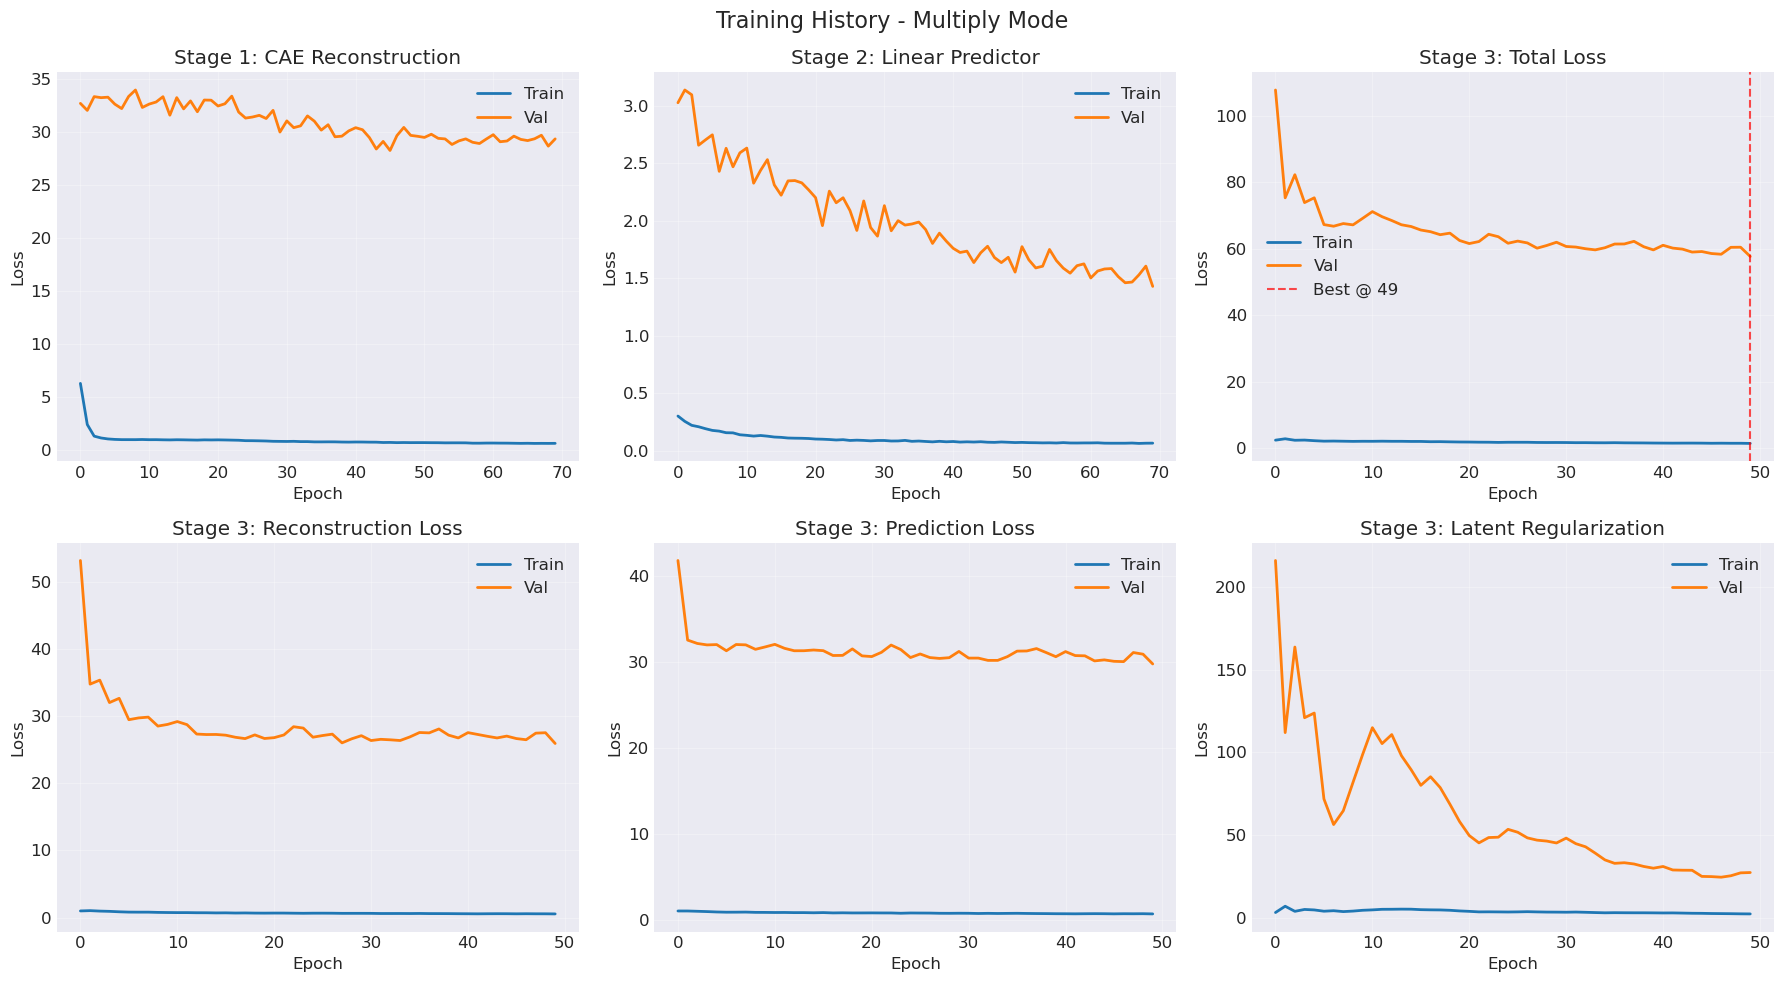


Final Training Metrics:
 Stage3 total final — train: 1.384075, val: 57.623379
 Best Stage3 val loss: 57.623379 @ epoch 49


In [9]:
# %% Plot training history
def plot_training_history(losses_data: dict, config: dict):
    """Plot comprehensive training history and print final metrics."""
    train_mode = config['training']['train_mode']
    train_losses = losses_data['train_losses']
    val_losses   = losses_data['val_losses']
    
    if train_mode == 'jointly':
        best_epoch = np.argmin(val_losses['total'])
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training History - Joint Mode', fontsize=16)
        
        # Total loss
        ax = axes[0, 0]
        ax.plot(train_losses['total'], label='Train', linewidth=2)
        ax.plot(val_losses['total'],   label='Val',   linewidth=2)
        ax.axvline(best_epoch, linestyle='--', color='red', alpha=0.7, 
                   label=f'Best @ {best_epoch}')
        ax.set_title('Total Loss')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Reconstruction loss
        ax = axes[0, 1]
        ax.plot(train_losses['reconstruction'], label='Train', linewidth=2)
        ax.plot(val_losses['reconstruction'],   label='Val',   linewidth=2)
        ax.set_title('Reconstruction Loss')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Prediction loss
        ax = axes[1, 0]
        ax.plot(train_losses['prediction'], label='Train', linewidth=2)
        ax.plot(val_losses['prediction'],   label='Val',   linewidth=2)
        ax.set_title('Prediction Loss')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Latent regularization
        ax = axes[1, 1]
        ax.plot(train_losses['latent_reg'], label='Train', linewidth=2)
        ax.plot(val_losses['latent_reg'],   label='Val',   linewidth=2)
        ax.set_title('Latent Regularization')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
    elif train_mode == 'separately':
        # Stage 1 & 2 each in one subplot
        tl1 = train_losses['stage1']
        vl1 = val_losses['stage1']
        tl2 = train_losses['stage2']
        vl2 = val_losses['stage2']
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle('Training History - Separate Mode', fontsize=16)
        
        # Stage 1
        ax = axes[0]
        ax.plot(tl1['reconstruction'], label='Train', linewidth=2)
        ax.plot(vl1['reconstruction'], label='Val',   linewidth=2)
        ax.set_title('Stage 1: CAE Reconstruction')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Stage 2
        ax = axes[1]
        ax.plot(tl2['prediction'], label='Train', linewidth=2)
        ax.plot(vl2['prediction'], label='Val',   linewidth=2)
        ax.set_title('Stage 2: Linear Predictor')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
    elif train_mode == 'multiply':
        # Stage 1, 2, 3 in 2×3 grid
        tl1 = train_losses['stage1']; vl1 = val_losses['stage1']
        tl2 = train_losses['stage2']; vl2 = val_losses['stage2']
        tl3 = train_losses['stage3']; vl3 = val_losses['stage3']
        best_epoch = np.argmin(vl3['total'])
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Training History - Multiply Mode', fontsize=16)
        
        # Stage1: Reconstruction
        ax = axes[0, 0]
        ax.plot(tl1['reconstruction'], label='Train', linewidth=2)
        ax.plot(vl1['reconstruction'], label='Val',   linewidth=2)
        ax.set_title('Stage 1: CAE Reconstruction')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Stage2: Prediction
        ax = axes[0, 1]
        ax.plot(tl2['prediction'], label='Train', linewidth=2)
        ax.plot(vl2['prediction'], label='Val',   linewidth=2)
        ax.set_title('Stage 2: Linear Predictor')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Stage3: Total
        ax = axes[0, 2]
        ax.plot(tl3['total'], label='Train', linewidth=2)
        ax.plot(vl3['total'], label='Val',   linewidth=2)
        ax.axvline(best_epoch, linestyle='--', color='red', alpha=0.7, 
                   label=f'Best @ {best_epoch}')
        ax.set_title('Stage 3: Total Loss')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Stage3: Reconstruction
        ax = axes[1, 0]
        ax.plot(tl3['reconstruction'], label='Train', linewidth=2)
        ax.plot(vl3['reconstruction'], label='Val',   linewidth=2)
        ax.set_title('Stage 3: Reconstruction Loss')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Stage3: Prediction
        ax = axes[1, 1]
        ax.plot(tl3['prediction'], label='Train', linewidth=2)
        ax.plot(vl3['prediction'], label='Val',   linewidth=2)
        ax.set_title('Stage 3: Prediction Loss')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
        # Stage3: Latent Reg
        ax = axes[1, 2]
        ax.plot(tl3['latent_reg'], label='Train', linewidth=2)
        ax.plot(vl3['latent_reg'], label='Val',   linewidth=2)
        ax.set_title('Stage 3: Latent Regularization')
        ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
        ax.legend(); ax.grid(True, alpha=0.3)
        
    else:
        raise ValueError(f"Unsupported train_mode: {train_mode}")
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("\nFinal Training Metrics:")
    if train_mode == 'jointly':
        print(f" Final train loss: {train_losses['total'][-1]:.6f}")
        print(f" Final val   loss: {val_losses['total'][-1]:.6f}")
        print(f" Best val    loss: {min(val_losses['total']):.6f} @ epoch {best_epoch}")
        
    elif train_mode == 'separately':
        # Stage1 & Stage2
        print(f" Stage1 (recon) final — train: {train_losses['stage1']['reconstruction'][-1]:.6f}, "
              f"val: {val_losses['stage1']['reconstruction'][-1]:.6f}")
        print(f" Stage2 (pred)  final — train: {train_losses['stage2']['prediction'][-1]:.6f}, "
              f"val: {val_losses['stage2']['prediction'][-1]:.6f}")
        
    else:  # multiply
        print(f" Stage3 total final — train: {train_losses['stage3']['total'][-1]:.6f}, "
              f"val: {val_losses['stage3']['total'][-1]:.6f}")
        print(f" Best Stage3 val loss: {min(val_losses['stage3']['total']):.6f} @ epoch {best_epoch}")
      

plot_training_history(losses_data, config)


## 3. Load Test Data and Evaluate Reconstruction Quality

Loaded Kolmogorov data with shape: (120, 320, 64, 64)
Reshaped data to: (120, 320, 4096)
Loaded Kolmogorov data with shape: (120, 320, 64, 64)
Reshaped data to: (120, 320, 4096)
Data shape: torch.Size([32, 4096])
Number of validation samples: 24


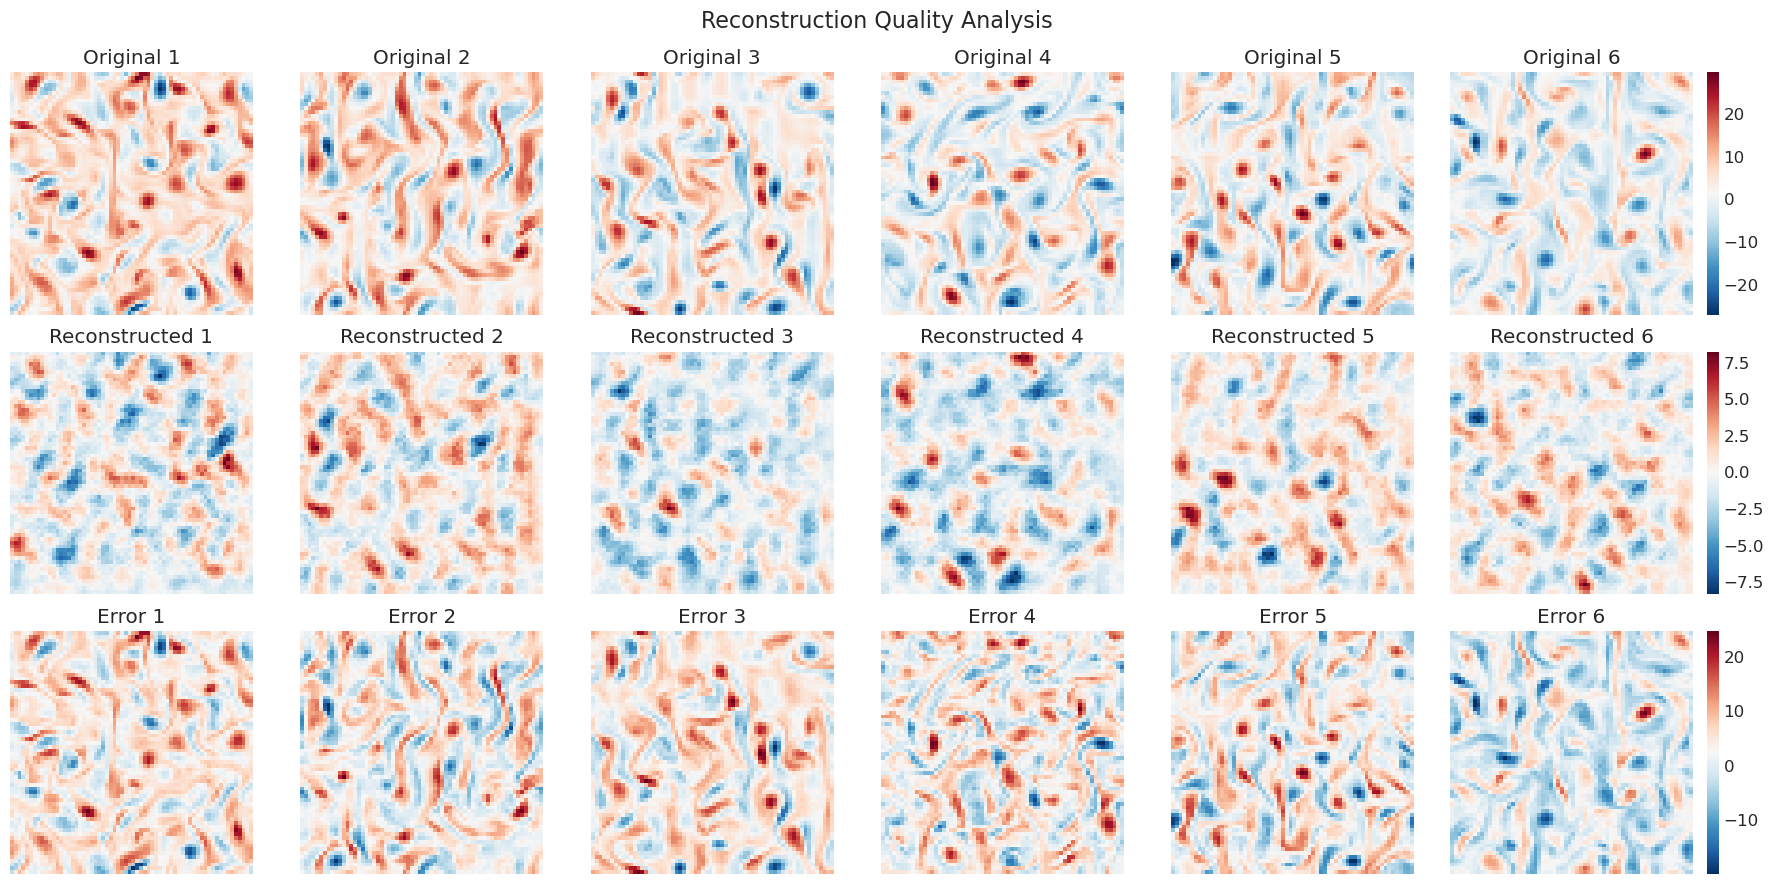


Reconstruction Metrics:
MSE: 27.361235
MAE: 3.966213
Relative Error: 90.5732%


In [10]:
# Create data loaders
config['dataset']['data_path'] = str(project_root / 'data')
train_loader, val_loader, data_info = create_caemlp_dataloaders(config['dataset'])

print(f"Data shape: {data_info['batch_shape']}")
print(f"Number of validation samples: {data_info['dataset_size_val']}")

# Get a batch of validation data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

with torch.no_grad():
    for x_t, x_next in val_loader:
        x_t = x_t.to(device)
        x_next = x_next.to(device)
        
        # Reshape for CAE
        x_t_cae = reshape_data_for_cae(x_t, 'kolmogorov', target_shape=(64, 64))
        x_next_cae = reshape_data_for_cae(x_next, 'kolmogorov', target_shape=(64, 64))
        
        # Get model outputs
        if isinstance(model, CAE_WeakLinearMLP):
            x_t_recon, x_next_pred, z_t, z_next, z_next_linear = model(x_t_cae)
        else:
            x_t_recon, x_next_pred, z_t, z_next = model(x_t_cae)
        
        break  # Just take first batch

# %% Visualize reconstruction quality
def visualize_reconstruction(x_true, x_recon, n_samples=6):
    """Visualize original vs reconstructed samples"""
    fig, axes = plt.subplots(3, n_samples, figsize=(n_samples*3, 9))
    
    for i in range(n_samples):
        # Original
        im1 = axes[0, i].imshow(x_true[i, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # Reconstruction
        im2 = axes[1, i].imshow(x_recon[i, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')
        
        # Error
        error = (x_true[i, 0] - x_recon[i, 0]).cpu().numpy()
        im3 = axes[2, i].imshow(error, cmap='RdBu_r', aspect='equal')
        axes[2, i].set_title(f'Error {i+1}')
        axes[2, i].axis('off')
        
        # Add colorbars
        if i == n_samples - 1:
            plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
            plt.colorbar(im2, ax=axes[1, i], fraction=0.046)
            plt.colorbar(im3, ax=axes[2, i], fraction=0.046)
    
    axes[0, 0].set_ylabel('Original', fontsize=14)
    axes[1, 0].set_ylabel('Reconstructed', fontsize=14)
    axes[2, 0].set_ylabel('Error', fontsize=14)
    
    plt.suptitle('Reconstruction Quality Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Calculate reconstruction metrics
    mse = nn.MSELoss()(x_true, x_recon).item()
    mae = nn.L1Loss()(x_true, x_recon).item()
    
    # Relative error
    rel_error = torch.norm(x_true - x_recon) / torch.norm(x_true)
    
    print(f"\nReconstruction Metrics:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"Relative Error: {rel_error:.4%}")

visualize_reconstruction(x_t_cae, x_t_recon)

## 4. Latent Space Analysis

Latent codes shape: (24, 64)


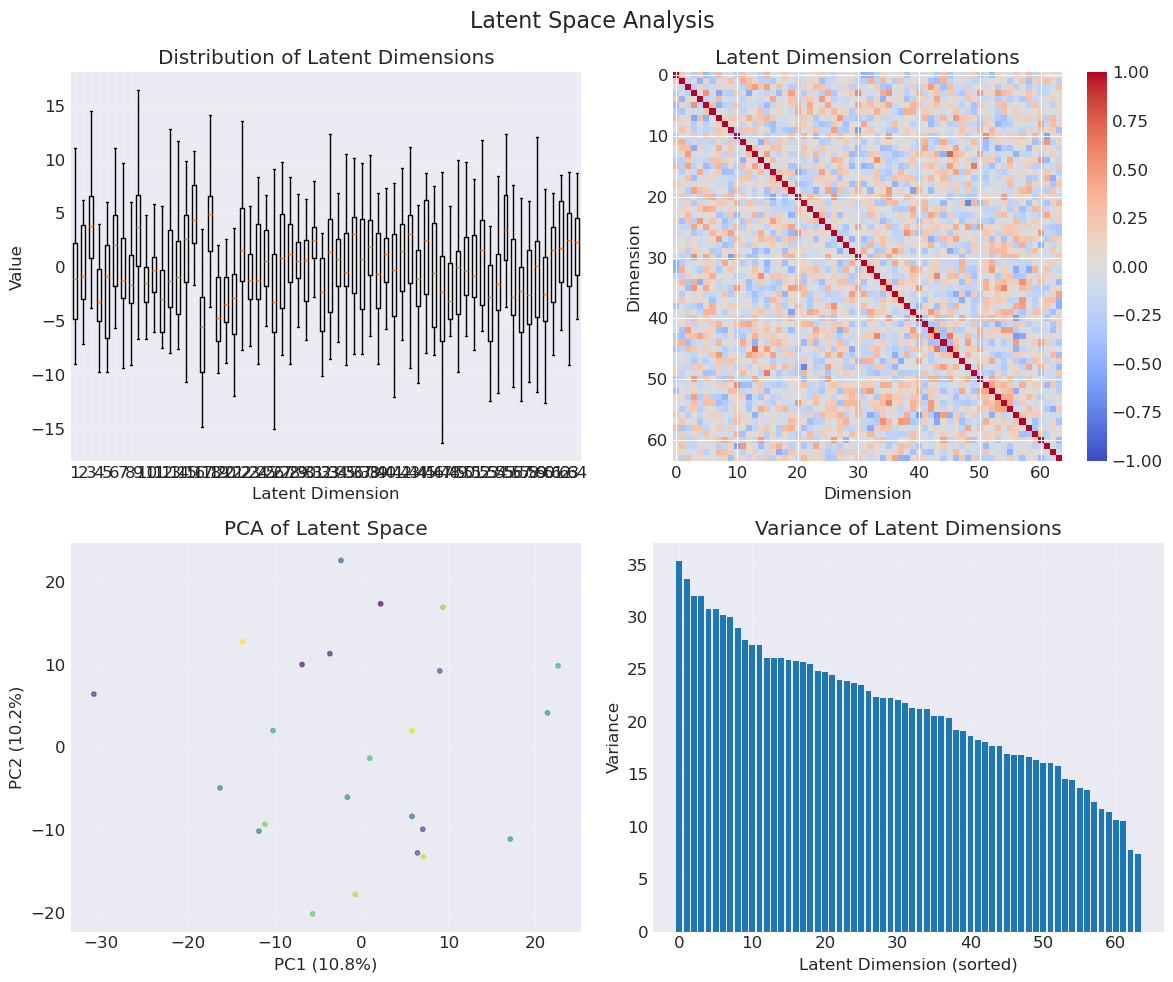


Latent Space Statistics:
Mean activation: -0.1304
Std activation: 5.1164
Sparsity (% near zero): 1.6%


In [11]:
# %% Analyze latent space
def analyze_latent_space(model, val_loader, device, n_batches=10):
    """Analyze the learned latent representations"""
    latent_codes = []
    
    model.eval()
    with torch.no_grad():
        for i, (x_t, _) in enumerate(val_loader):
            if i >= n_batches:
                break
                
            x_t = x_t.to(device)
            x_t_cae = reshape_data_for_cae(x_t, 'kolmogorov', target_shape=(64, 64))
            
            # Encode
            z_t = model.cae.encode(x_t_cae)
            latent_codes.append(z_t.cpu().numpy())
    
    latent_codes = np.concatenate(latent_codes, axis=0)
    return latent_codes

# Get latent codes
latent_codes = analyze_latent_space(model, val_loader, device)
print(f"Latent codes shape: {latent_codes.shape}")

# Visualize latent space statistics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Distribution of latent dimensions
ax = axes[0, 0]
ax.boxplot(latent_codes, showfliers=False)
ax.set_xlabel('Latent Dimension')
ax.set_ylabel('Value')
ax.set_title('Distribution of Latent Dimensions')
ax.grid(True, alpha=0.3)

# Correlation matrix
ax = axes[0, 1]
corr_matrix = np.corrcoef(latent_codes.T)
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal')
ax.set_title('Latent Dimension Correlations')
ax.set_xlabel('Dimension')
ax.set_ylabel('Dimension')
plt.colorbar(im, ax=ax)

# PCA of latent space
ax = axes[1, 0]
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_codes)
scatter = ax.scatter(latent_pca[:, 0], latent_pca[:, 1], c=range(len(latent_pca)), 
                    cmap='viridis', alpha=0.6, s=10)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA of Latent Space')
ax.grid(True, alpha=0.3)

# Variance explained
ax = axes[1, 1]
latent_var = np.var(latent_codes, axis=0)
sorted_indices = np.argsort(latent_var)[::-1]
ax.bar(range(len(latent_var)), latent_var[sorted_indices])
ax.set_xlabel('Latent Dimension (sorted)')
ax.set_ylabel('Variance')
ax.set_title('Variance of Latent Dimensions')
ax.grid(True, alpha=0.3)

plt.suptitle('Latent Space Analysis', fontsize=16)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nLatent Space Statistics:")
print(f"Mean activation: {np.mean(latent_codes):.4f}")
print(f"Std activation: {np.std(latent_codes):.4f}")
print(f"Sparsity (% near zero): {np.mean(np.abs(latent_codes) < 0.1):.1%}")


## 5. Prediction Accuracy Assessment

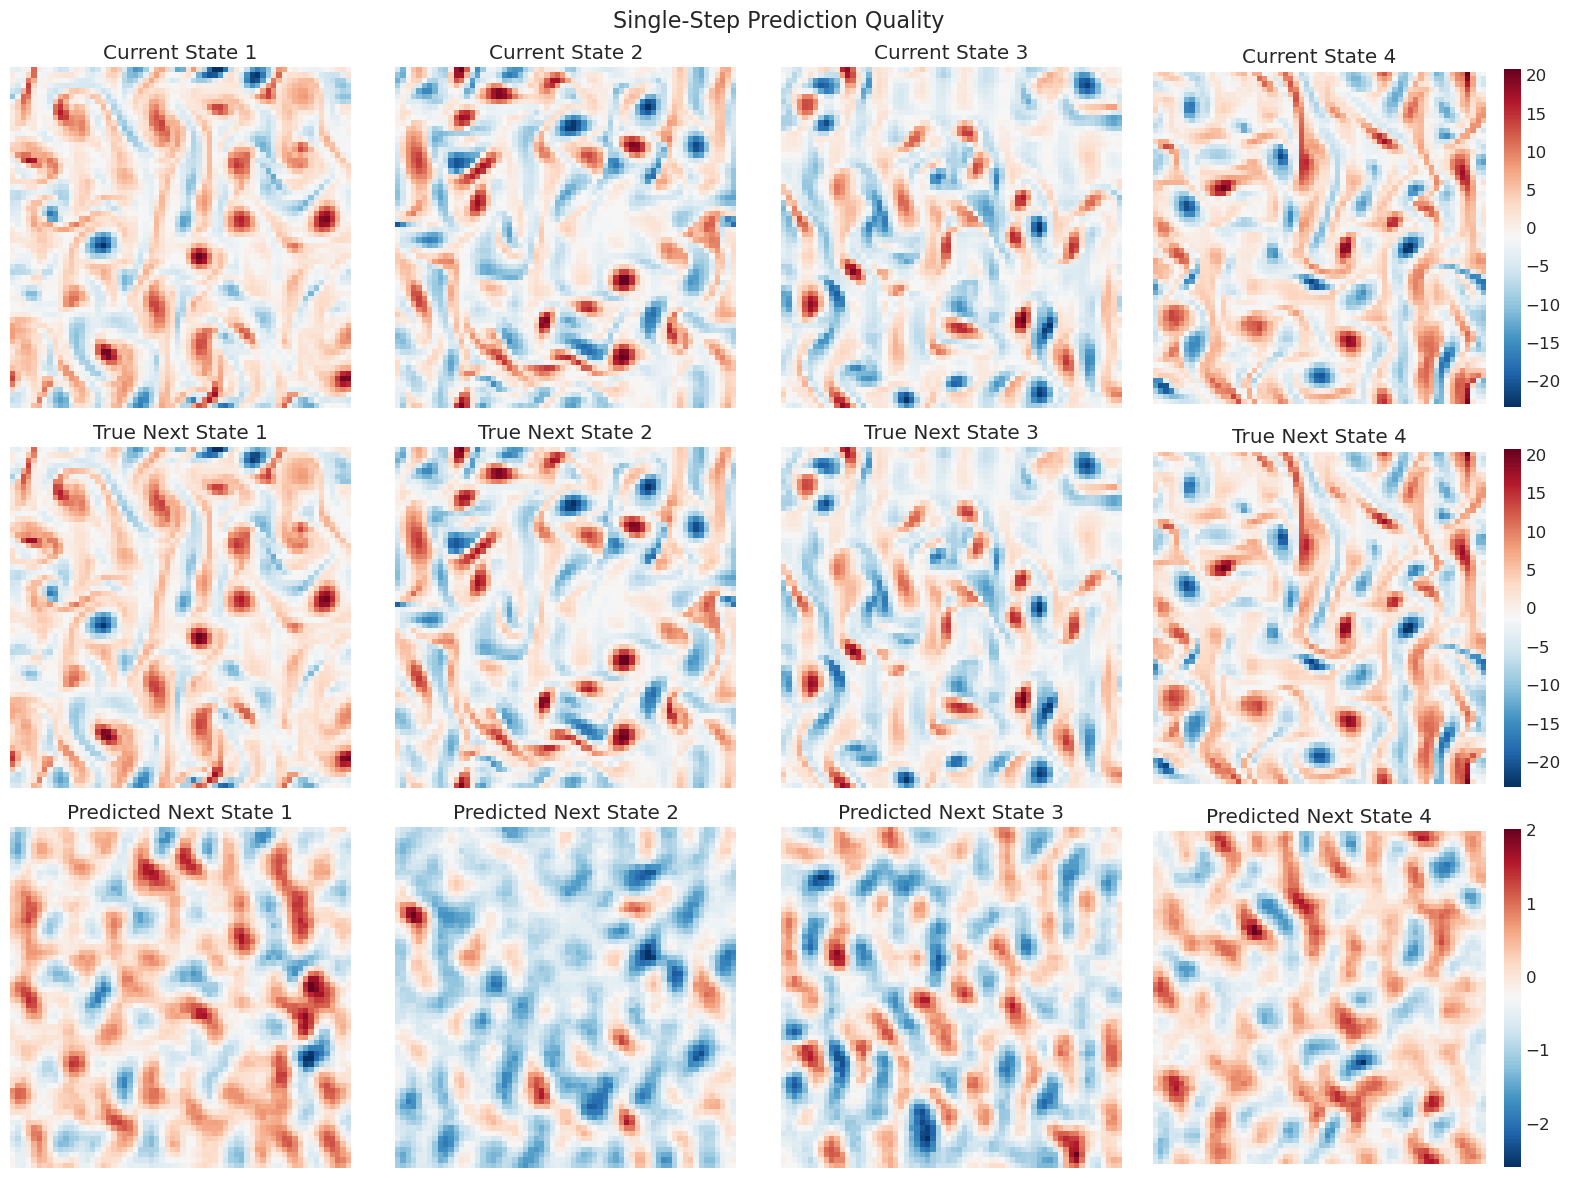


Prediction Metrics:
MSE: 29.652252
MAE: 4.060621
Relative Error: 96.6872%


In [12]:
# %% Evaluate prediction accuracy
def evaluate_predictions(model, val_loader, device, n_steps=5):
    """Evaluate multi-step prediction accuracy"""
    errors = {i: [] for i in range(1, n_steps+1)}
    
    model.eval()
    with torch.no_grad():
        for x_t, x_next in val_loader:
            x_t = x_t.to(device)
            x_next = x_next.to(device)
            
            # Reshape for CAE
            x_t_cae = reshape_data_for_cae(x_t, 'kolmogorov', target_shape=(64, 64))
            x_next_cae = reshape_data_for_cae(x_next, 'kolmogorov', target_shape=(64, 64))
            
            # Single-step prediction
            if isinstance(model, CAE_WeakLinearMLP):
                _, x_next_pred, _, _, _ = model(x_t_cae)
            else:
                _, x_next_pred, _, _ = model(x_t_cae)
            
            # Calculate error
            error = nn.MSELoss()(x_next_pred, x_next_cae).item()
            errors[1].append(error)
            
            # Multi-step predictions (if we have sequential data)
            # Note: This requires modification based on actual data structure
            
            break  # For now, just evaluate on one batch
    
    return errors

# Evaluate predictions
prediction_errors = evaluate_predictions(model, val_loader, device, n_steps=1)

# Visualize prediction quality
with torch.no_grad():
    # Get one batch for visualization
    for x_t, x_next in val_loader:
        x_t = x_t.to(device)
        x_next = x_next.to(device)
        
        x_t_cae = reshape_data_for_cae(x_t, 'kolmogorov', target_shape=(64, 64))
        x_next_cae = reshape_data_for_cae(x_next, 'kolmogorov', target_shape=(64, 64))
        
        if isinstance(model, CAE_WeakLinearMLP):
            _, x_next_pred, _, _, _ = model(x_t_cae)
        else:
            _, x_next_pred, _, _ = model(x_t_cae)
        
        break

# Visualize predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Current state
    im1 = axes[0, i].imshow(x_t_cae[i, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
    axes[0, i].set_title(f'Current State {i+1}')
    axes[0, i].axis('off')
    
    # True next state
    im2 = axes[1, i].imshow(x_next_cae[i, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
    axes[1, i].set_title(f'True Next State {i+1}')
    axes[1, i].axis('off')
    
    # Predicted next state
    im3 = axes[2, i].imshow(x_next_pred[i, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
    axes[2, i].set_title(f'Predicted Next State {i+1}')
    axes[2, i].axis('off')
    
    if i == 3:
        plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
        plt.colorbar(im2, ax=axes[1, i], fraction=0.046)
        plt.colorbar(im3, ax=axes[2, i], fraction=0.046)

axes[0, 0].set_ylabel('$x_t$', fontsize=14)
axes[1, 0].set_ylabel('$x_{t+1}$ (True)', fontsize=14)
axes[2, 0].set_ylabel('$x_{t+1}$ (Pred)', fontsize=14)

plt.suptitle('Single-Step Prediction Quality', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate prediction metrics
pred_mse = nn.MSELoss()(x_next_pred, x_next_cae).item()
pred_mae = nn.L1Loss()(x_next_pred, x_next_cae).item()
pred_rel_error = torch.norm(x_next_pred - x_next_cae) / torch.norm(x_next_cae)

print(f"\nPrediction Metrics:")
print(f"MSE: {pred_mse:.6f}")
print(f"MAE: {pred_mae:.6f}")
print(f"Relative Error: {pred_rel_error:.4%}")

## 6. Spectral Analysis and Energy Conservation

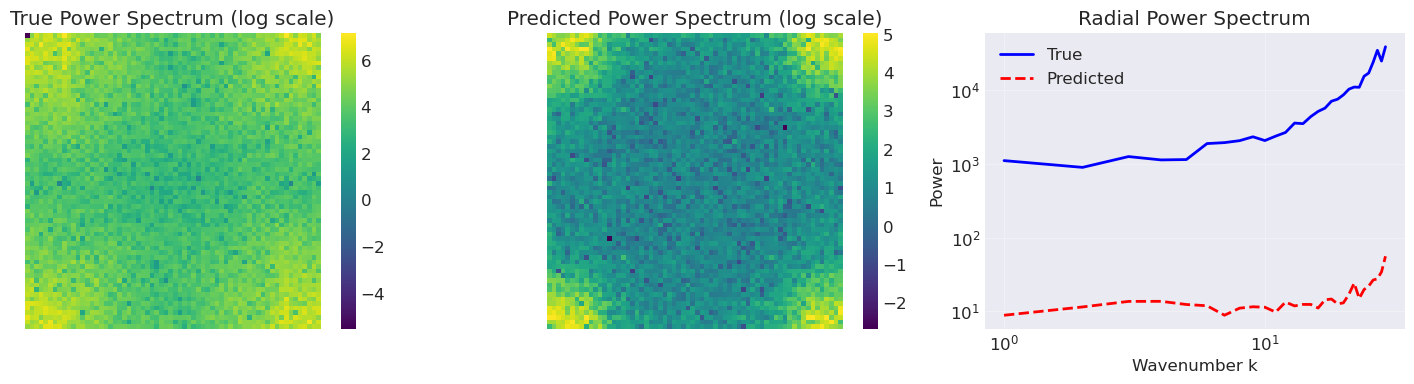


Energy Conservation:
True field energy: 125932.0000
Predicted field energy: 1662.8298
Energy ratio: 0.0132


In [13]:
# %% Analyze spectral properties
def spectral_analysis(x_true, x_pred):
    """Analyze spectral properties of true vs predicted fields"""
    # Convert to numpy
    x_true_np = x_true[0, 0].cpu().numpy()
    x_pred_np = x_pred[0, 0].cpu().numpy()
    
    # Compute 2D FFT
    fft_true = np.fft.fft2(x_true_np)
    fft_pred = np.fft.fft2(x_pred_np)
    
    # Power spectrum
    power_true = np.abs(fft_true)**2
    power_pred = np.abs(fft_pred)**2
    
    # Radial average
    def radial_profile(data, center=None):
        y, x = np.indices(data.shape)
        if center is None:
            center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        r = r.astype(int)
        
        tbin = np.bincount(r.ravel(), data.ravel())
        nr = np.bincount(r.ravel())
        radialprofile = tbin / nr
        
        return radialprofile
    
    # Compute radial profiles
    radial_true = radial_profile(power_true)
    radial_pred = radial_profile(power_pred)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Power spectra
    ax = axes[0]
    im1 = ax.imshow(np.log10(power_true + 1e-10), cmap='viridis', aspect='equal')
    ax.set_title('True Power Spectrum (log scale)')
    ax.axis('off')
    plt.colorbar(im1, ax=ax, fraction=0.046)
    
    ax = axes[1]
    im2 = ax.imshow(np.log10(power_pred + 1e-10), cmap='viridis', aspect='equal')
    ax.set_title('Predicted Power Spectrum (log scale)')
    ax.axis('off')
    plt.colorbar(im2, ax=ax, fraction=0.046)
    
    # Radial profiles
    ax = axes[2]
    k = np.arange(len(radial_true))
    ax.loglog(k[1:30], radial_true[1:30], 'b-', label='True', linewidth=2)
    ax.loglog(k[1:30], radial_pred[1:30], 'r--', label='Predicted', linewidth=2)
    ax.set_xlabel('Wavenumber k')
    ax.set_ylabel('Power')
    ax.set_title('Radial Power Spectrum')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Energy conservation
    energy_true = np.sum(x_true_np**2)
    energy_pred = np.sum(x_pred_np**2)
    energy_ratio = energy_pred / energy_true
    
    print(f"\nEnergy Conservation:")
    print(f"True field energy: {energy_true:.4f}")
    print(f"Predicted field energy: {energy_pred:.4f}")
    print(f"Energy ratio: {energy_ratio:.4f}")

# Analyze spectral properties
spectral_analysis(x_next_cae, x_next_pred)

## 7. Model Dynamics Analysis

In [14]:
# %% Analyze linear dynamics in latent space
if isinstance(model, CAE_LinearMLP):
    # Get the linear transformation matrix
    A = model.dynamics.get_weight_matrix().detach().cpu().numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Visualize the matrix
    ax = axes[0, 0]
    im = ax.imshow(A, cmap='RdBu_r', aspect='equal')
    ax.set_title('Linear Dynamics Matrix A')
    ax.set_xlabel('Input Dimension')
    ax.set_ylabel('Output Dimension')
    plt.colorbar(im, ax=ax)
    
    # Eigenvalue analysis
    eigenvalues = np.linalg.eigvals(A)
    
    ax = axes[0, 1]
    ax.scatter(eigenvalues.real, eigenvalues.imag, alpha=0.6, s=50)
    circle = plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_patch(circle)
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title('Eigenvalues of Dynamics Matrix')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    # Eigenvalue magnitudes
    ax = axes[1, 0]
    eig_mags = np.abs(eigenvalues)
    ax.hist(eig_mags, bins=30, alpha=0.7, edgecolor='black')
    ax.axvline(1.0, color='red', linestyle='--', label='Unit circle')
    ax.set_xlabel('Eigenvalue Magnitude')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Eigenvalue Magnitudes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Singular values
    ax = axes[1, 1]
    singular_values = np.linalg.svd(A, compute_uv=False)
    ax.semilogy(singular_values, 'bo-', linewidth=2, markersize=4)
    ax.set_xlabel('Index')
    ax.set_ylabel('Singular Value')
    ax.set_title('Singular Values of Dynamics Matrix')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Linear Dynamics Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nLinear Dynamics Statistics:")
    print(f"Matrix shape: {A.shape}")
    print(f"Condition number: {np.linalg.cond(A):.4f}")
    print(f"Largest eigenvalue magnitude: {np.max(eig_mags):.4f}")
    print(f"Smallest eigenvalue magnitude: {np.min(eig_mags):.4f}")
    print(f"Number of eigenvalues |λ| > 1: {np.sum(eig_mags > 1)}")


## 8. Long-term Prediction Stability

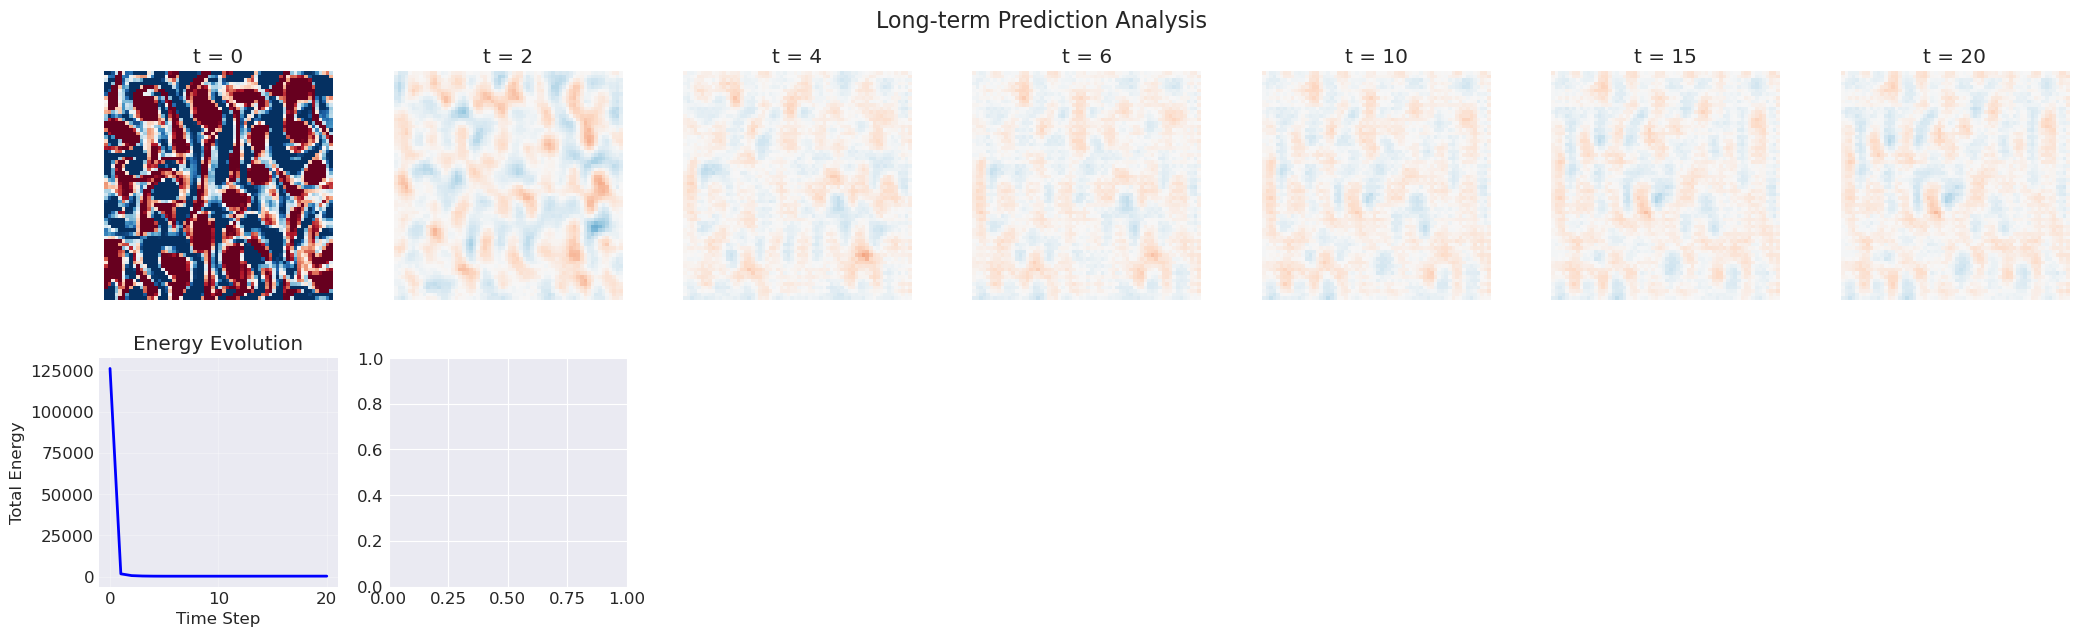


Long-term Prediction Statistics:
Initial energy: 126085.5078
Final energy: 265.5578
Energy change: -99.79%
Initial std: 5.5482
Final std: 0.2523


In [15]:
# %% Test long-term predictions
def long_term_prediction(model, x_0, n_steps=50):
    """Generate long-term predictions"""
    predictions = [x_0]
    
    model.eval()
    with torch.no_grad():
        x_current = x_0
        
        for step in range(n_steps):
            # Predict next state
            if isinstance(model, CAE_WeakLinearMLP):
                _, x_next, _, _, _ = model(x_current)
            else:
                _, x_next, _, _ = model(x_current)
            
            predictions.append(x_next)
            x_current = x_next
    
    return torch.stack(predictions)

# Generate long-term predictions
n_future_steps = 20
with torch.no_grad():
    # Take one sample
    x_0 = x_t_cae[0:1]  # Keep batch dimension
    predictions = long_term_prediction(model, x_0, n_steps=n_future_steps)

# Visualize long-term predictions
fig, axes = plt.subplots(3, 7, figsize=(21, 9))

# Select time steps to visualize
time_steps = [0, 2, 4, 6, 10, 15, 20]

for i, t in enumerate(time_steps):
    if t < len(predictions):
        im = axes[0, i].imshow(predictions[t, 0, 0].cpu().numpy(), 
                              cmap='RdBu_r', aspect='equal', vmin=-3, vmax=3)
        axes[0, i].set_title(f't = {t}')
        axes[0, i].axis('off')

axes[0, 0].set_ylabel('Prediction', fontsize=14)

# Analyze prediction statistics over time
pred_energies = []
pred_stds = []

for t in range(len(predictions)):
    pred_t = predictions[t, 0, 0].cpu().numpy()
    pred_energies.append(np.sum(pred_t**2))
    pred_stds.append(np.std(pred_t))

# Plot statistics
ax = axes[1, :3].flatten()[0]
ax.plot(pred_energies, 'b-', linewidth=2)
ax.set_xlabel('Time Step')
ax.set_ylabel('Total Energy')
ax.set_title('Energy Evolution')
ax.grid(True, alpha=0.3)

ax = axes[1, 3:6].flatten()[0]
ax.plot(pred_stds, 'r-', linewidth=2)
ax.set_xlabel('Time Step')
ax.set_ylabel('Standard Deviation')
ax.set_title('Variance Evolution')
ax.grid(True, alpha=0.3)

# Remove unused axes
for ax in axes[1, :].flatten()[2:]:
    ax.remove()
for ax in axes[2, :].flatten():
    ax.remove()

plt.suptitle('Long-term Prediction Analysis', fontsize=16)
plt.tight_layout()
plt.show()

print(f"\nLong-term Prediction Statistics:")
print(f"Initial energy: {pred_energies[0]:.4f}")
print(f"Final energy: {pred_energies[-1]:.4f}")
print(f"Energy change: {(pred_energies[-1]/pred_energies[0] - 1)*100:.2f}%")
print(f"Initial std: {pred_stds[0]:.4f}")
print(f"Final std: {pred_stds[-1]:.4f}")

## 9. Additional Analysis: Interpolation in Latent Space

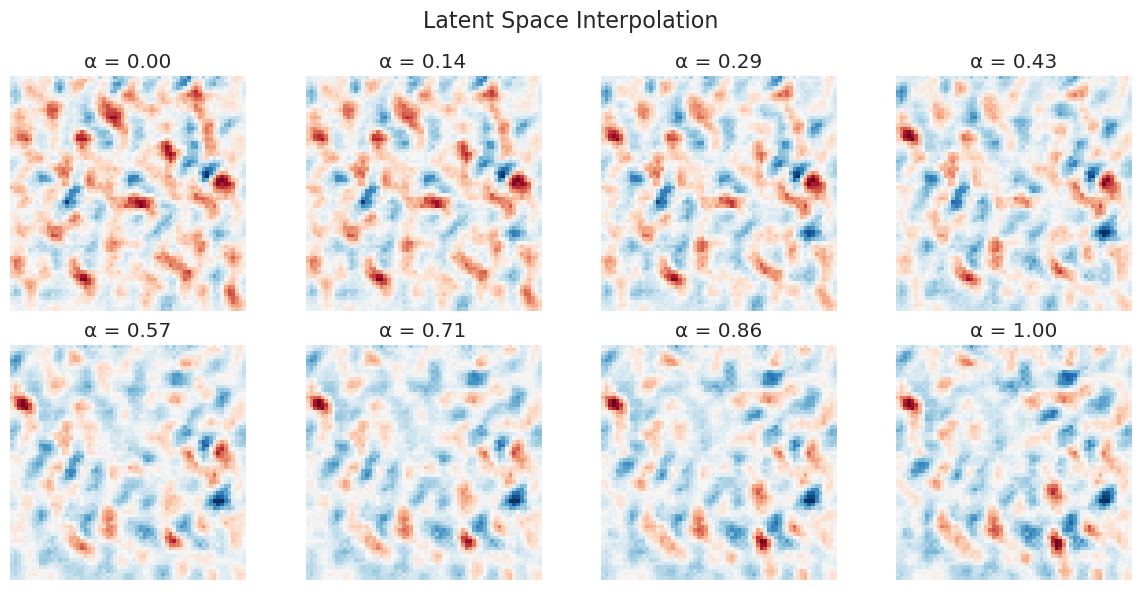

In [16]:
# %% Latent space interpolation
def interpolate_latent_space(model, val_loader, device, n_interp=8):
    """Interpolate between two states in latent space"""
    model.eval()
    
    # Get two random samples
    with torch.no_grad():
        for x_batch, _ in val_loader:
            x_batch = x_batch.to(device)
            x_batch = reshape_data_for_cae(x_batch, 'kolmogorov', target_shape=(64, 64))
            
            # Take two samples
            x1 = x_batch[0:1]
            x2 = x_batch[1:2]
            
            # Encode
            z1 = model.cae.encode(x1)
            z2 = model.cae.encode(x2)
            
            break
    
    # Interpolate in latent space
    interpolations = []
    alphas = np.linspace(0, 1, n_interp)
    
    with torch.no_grad():
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            x_interp = model.cae.decode(z_interp)
            interpolations.append(x_interp)
    
    # Visualize
    fig, axes = plt.subplots(2, n_interp//2, figsize=(n_interp//2 * 3, 6))
    axes = axes.flatten()
    
    for i, (alpha, x_interp) in enumerate(zip(alphas, interpolations)):
        im = axes[i].imshow(x_interp[0, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
        axes[i].set_title(f'α = {alpha:.2f}')
        axes[i].axis('off')
    
    plt.suptitle('Latent Space Interpolation', fontsize=16)
    plt.tight_layout()
    plt.show()

# Perform interpolation
interpolate_latent_space(model, val_loader, device)

## 11. Save Analysis Results

In [17]:
# %% Save analysis results
analysis_results = {
    'experiment_path': str(experiment_path),
    'model_type': config['model']['type'],
    'training_mode': config['training']['train_mode'],
    'latent_dim': config['model']['params']['latent_dim'],
    'performance_metrics': {
        'best_val_loss': float(checkpoint.get('best_val_loss', 0)),
        'best_epoch': int(checkpoint.get('best_epoch', 0)),
        'prediction_mse': float(pred_mse),
        'prediction_relative_error': float(pred_rel_error)
    },
    'latent_space_stats': {
        'mean_activation': float(np.mean(latent_codes)),
        'std_activation': float(np.std(latent_codes)),
        'sparsity': float(np.mean(np.abs(latent_codes) < 0.1))
    },
    'long_term_stability': {
        'n_steps': n_future_steps,
        'energy_drift_percent': float((pred_energies[-1]/pred_energies[0] - 1)*100),
        'std_drift': float(pred_stds[-1] - pred_stds[0])
    }
}

# Add linear dynamics stats if applicable
if isinstance(model, CAE_LinearMLP):
    analysis_results['linear_dynamics'] = {
        'condition_number': float(np.linalg.cond(A)),
        'max_eigenvalue_magnitude': float(np.max(eig_mags)),
        'min_eigenvalue_magnitude': float(np.min(eig_mags)),
        'stable_eigenvalues': int(np.sum(eig_mags <= 1)),
        'total_eigenvalues': len(eig_mags)
    }

# Save to JSON
analysis_path = experiment_path / 'analysis_results.json'
with open(analysis_path, 'w') as f:
    json.dump(analysis_results, f, indent=4)

print(f"\nAnalysis results saved to: {analysis_path}")


Analysis results saved to: /rds/general/user/wy524/home/ESEProjects/IRP/irp-test-framework/results/checkpoints/CAE_MLP/kolmogorov_CAE_WeakLinearMLP_20250618_170925/analysis_results.json


## 12. Generate Report Figures

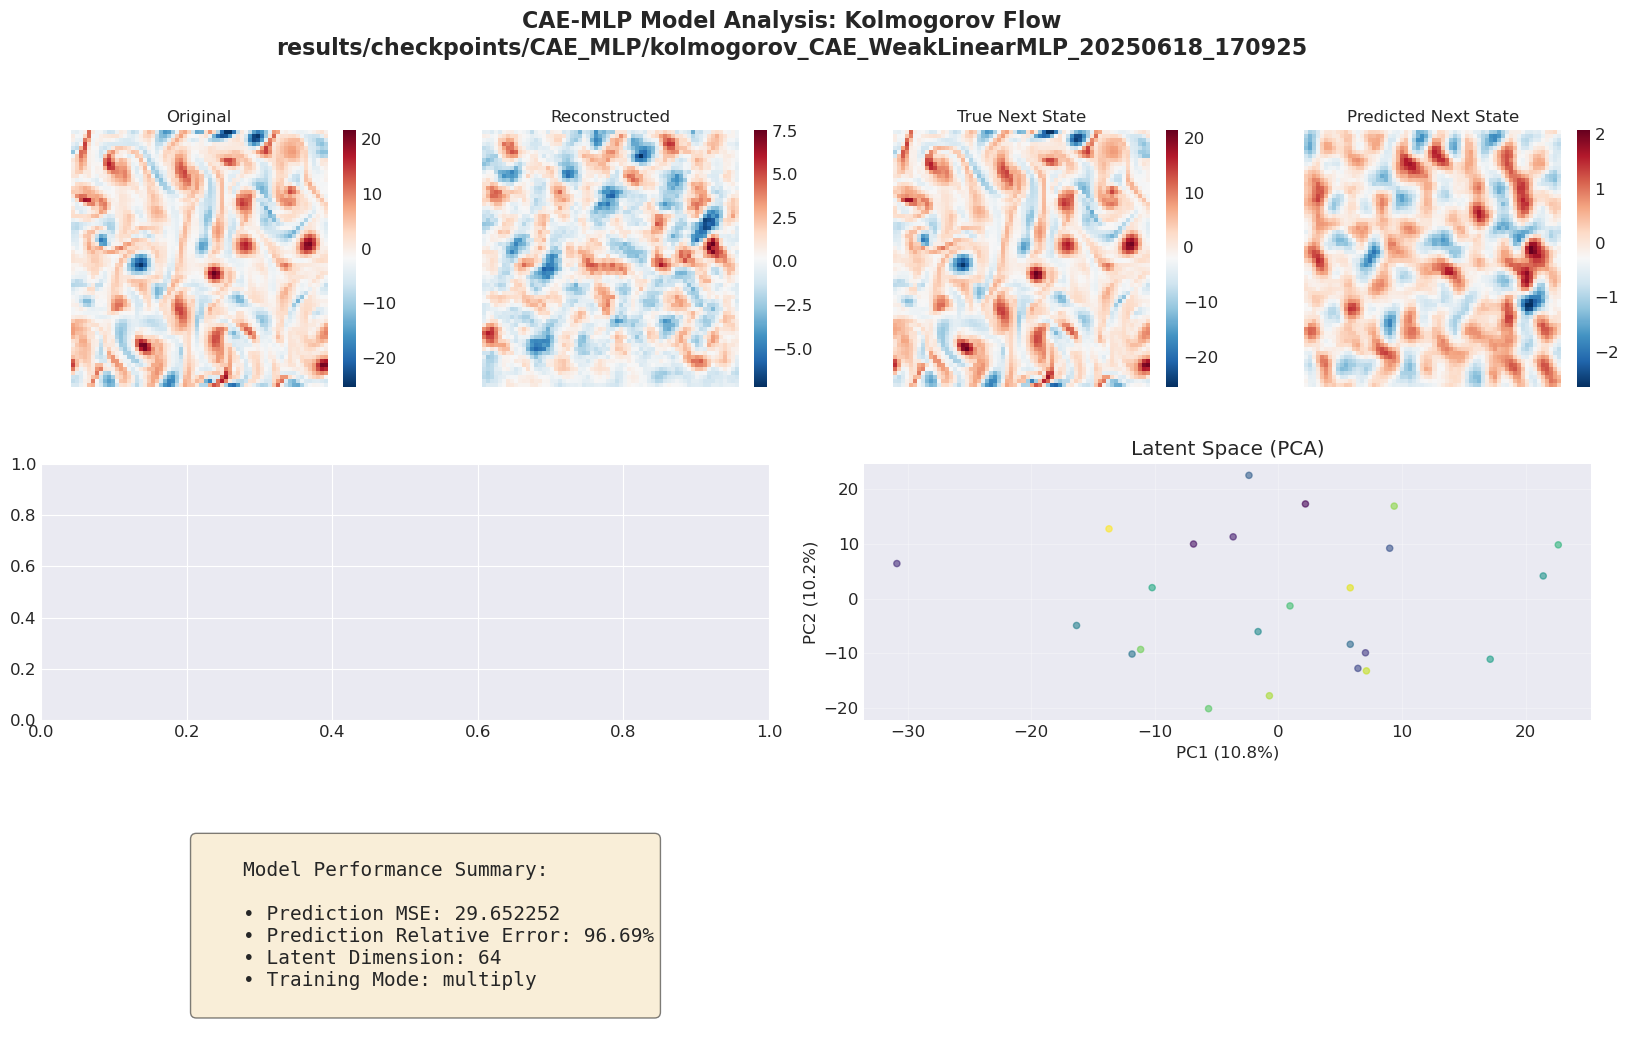

Summary figure saved to: /rds/general/user/wy524/home/ESEProjects/IRP/irp-test-framework/results/checkpoints/CAE_MLP/kolmogorov_CAE_WeakLinearMLP_20250618_170925/summary_figure.png


In [18]:
def create_summary_figure(model, x_t_cae, x_t_recon, x_next_cae, x_next_pred, latent_codes, save_path):
    """Create a comprehensive summary figure"""
    fig = plt.figure(figsize=(20, 12))
    
    # Define grid
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. Reconstruction example
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(x_t_cae[0, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
    ax1.set_title('Original', fontsize=12)
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, fraction=0.046)
    
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(x_t_recon[0, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
    ax2.set_title('Reconstructed', fontsize=12)
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, fraction=0.046)
    
    # 2. Prediction example
    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(x_next_cae[0, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
    ax3.set_title('True Next State', fontsize=12)
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, fraction=0.046)
    
    ax4 = fig.add_subplot(gs[0, 3])
    im4 = ax4.imshow(x_next_pred[0, 0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
    ax4.set_title('Predicted Next State', fontsize=12)
    ax4.axis('off')
    plt.colorbar(im4, ax=ax4, fraction=0.046)
    
    # 3. Training curves
    ax5 = fig.add_subplot(gs[1, :2])
    if 'jointly' in history.get('train_mode', 'jointly'):
        train_loss = losses_data['train_losses']['total']
        val_loss = losses_data['val_losses']['total']
        ax5.plot(train_loss, label='Train', linewidth=2)
        ax5.plot(val_loss, label='Validation', linewidth=2)
        ax5.set_xlabel('Epoch')
        ax5.set_ylabel('Total Loss')
        ax5.set_title('Training Progress')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        ax5.set_yscale('log')
    
    # 4. Latent space visualization
    ax6 = fig.add_subplot(gs[1, 2:])
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_codes[:500])  # Use subset for clarity
    scatter = ax6.scatter(latent_pca[:, 0], latent_pca[:, 1], 
                         c=range(len(latent_pca)), cmap='viridis', 
                         alpha=0.6, s=20)
    ax6.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax6.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax6.set_title('Latent Space (PCA)')
    ax6.grid(True, alpha=0.3)
    
    # 5. Performance metrics
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('off')
    
    metrics_text = f"""
    Model Performance Summary:
    
    • Prediction MSE: {pred_mse:.6f}
    • Prediction Relative Error: {pred_rel_error:.2%}
    • Latent Dimension: {config['model']['params']['latent_dim']}
    • Training Mode: {config['training']['train_mode']}
    """
    
    ax7.text(0.1, 0.5, metrics_text, fontsize=14, 
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'CAE-MLP Model Analysis: Kolmogorov Flow\n{experiment_folder}', 
                 fontsize=16, fontweight='bold')
    
    # Save figure
    fig_path = save_path / 'summary_figure.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.savefig(save_path / 'summary_figure.pdf', bbox_inches='tight')
    plt.show()
    
    print(f"Summary figure saved to: {fig_path}")

# Create summary figure
create_summary_figure(model, x_t_cae, x_t_recon, x_next_cae, x_next_pred, 
                     latent_codes, experiment_path)